In [1]:
from __future__ import division
from os.path import basename, splitext
import glob
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
import os
os.getcwd()

'C:\\Users\\Peter\\Documents\\Bitbucket\\pyColocalizer'

In [3]:
in_file = "data/dapi_cd9.tif"

In [4]:
with tiff.TiffFile(in_file) as tif:
        images = tif.asarray()

ch1 = 0
ch2 = 1

img_shape = images[0].shape

def imgToDataframe():
    """Function to transform all channels of open tif connection to columns in a DataFrame."""
    d = {}
    for i, data in enumerate(images):
        d["chan{}".format(i + 1)] = images[i].flatten()
    return pd.DataFrame(d)

df = imgToDataframe()

df_filter = df.copy()

df_filter[(df_filter.iloc[:, ch1] == 0) & (df_filter.iloc[:, ch2] == 0)] = np.nan

df_fix = df_filter - df_filter.min()

df_fix[(df_fix.iloc[:, ch1] < (0 * df_fix.iloc[:, ch1].max())) &
       (df_fix.iloc[:, ch2] < (0 * df_fix.iloc[:, ch2].max()))] = np.nan

# if (df_fix.iloc[:, ch1].max() >= 65535) | (df_fix.iloc[:, ch2].max() >= 65535):
#     df_fix[(df_fix.iloc[:, ch1] >= 65535) | (df_fix.iloc[:, ch2] >= 65535) ] = np.nan
# elif (df_fix.iloc[:, ch1].max() >= 4095) | (df_fix.iloc[:, ch2].max() >= 4095):
#     df_fix[(df_fix.iloc[:, ch1] >= 4095) | (df_fix.iloc[:, ch2] >= 4095) ] = np.nan
# elif (df_fix.iloc[:, ch1].max() >= 255) | (df_fix.iloc[:, ch2].max() >= 255):
#     df_fix[(df_fix.iloc[:, ch1] >= 255) | (df_fix.iloc[:, ch2] >= 255) ] = np.nan

df_mean = df_fix / np.mean(df_fix)

df_X = df_mean.iloc[:, ch1].dropna().values.reshape(-1, 1)
df_y = df_mean.iloc[:, ch2].dropna().values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(X=df_X, y=df_y)
predictions = lm.predict(df_X)
predictions_x = lm.predict(df_y)
rsquared = r2_score(df_y, predictions)
coef = lm.coef_

residuals = df_y - predictions
residuals_x = df_X - predictions_x

residuals_normx = residuals / (df_X + 1)

img_name = splitext(basename(in_file))[0]

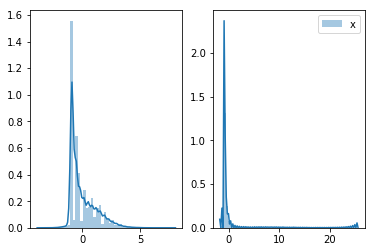

In [5]:
fig, ax = plt.subplots(ncols=2)
sns.distplot(residuals, label="y", ax=ax[0])
sns.distplot(residuals_x, label="x", ax=ax[1])
plt.legend()

In [6]:
df_mean['residuals'] = pd.DataFrame(residuals, index = df_mean['chan1'].dropna().index)

In [11]:
abs_resi = df_mean['residuals'] + abs(df_mean['residuals'].min())

In [24]:
np.argwhere(np.isnan(df_mean.iloc[:, 0]))

array([[    0],
       [    1],
       [    2],
       ..., 
       [93402],
       [93403],
       [93404]], dtype=int64)

In [62]:
minval = abs(df_mean['residuals']).min()
maxval = df_mean['residuals'].max()

In [63]:
minval

0.00073569570268627871

AttributeError: 'AxesImage' object has no attribute 'clim'

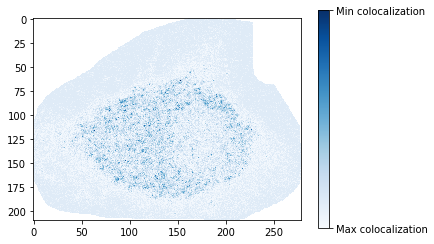

In [69]:
fig, ax = plt.subplots()
cax = ax.imshow(abs(df_mean['residuals']).values.reshape(img_shape), cmap = "Blues")
cbar = fig.colorbar(cax, ticks=[minval, maxval])
cbar.ax.set_yticklabels(['Max colocalization', 'Min colocalization'])
cax.clim(0, maxval)
plt.xticks(())
plt.yticks(())
plt.show()



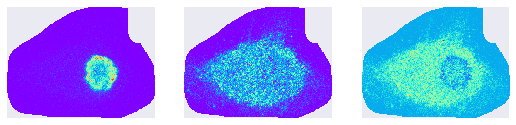

In [90]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(9,9))
G = gridspec.GridSpec(1, 3)

ax1 = plt.subplot(G[0,0])
ax1 = plt.imshow(df_mean["chan1"].values.reshape(img_shape), cmap="rainbow")
plt.xticks(())
plt.yticks(())

ax2 = plt.subplot(G[0,1])
ax2 = plt.imshow(df_mean["chan2"].values.reshape(img_shape), cmap="rainbow")
plt.xticks(())
plt.yticks(())

ax3 = plt.subplot(G[0,2])
ax3 = plt.imshow(df_mean["residuals"].values.reshape(img_shape), cmap="rainbow")
plt.xticks(())
plt.yticks(())

plt.show()

In [3]:
test_array = np.array([np.nan, 5, 3, 8, np.nan, np.nan, 9, np.nan, 4, np.nan])

In [6]:
test_df = pd.DataFrame(test_array)

In [9]:
no_nan = test_df.dropna()

In [14]:
no_nan.index

Int64Index([1, 2, 3, 6, 8], dtype='int64')

In [15]:
changed = np.array(no_nan + 5)

In [74]:
changed_df = pd.DataFrame(changed, index = no_nan.index)
changed_df

,0
1,10.0
2,8.0
3,13.0
6,14.0
8,9.0


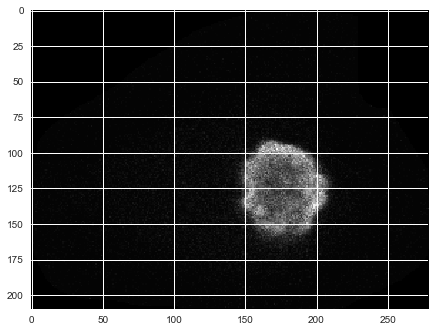

In [27]:
plt.imshow(images[0], cmap="gray")

plt.show()

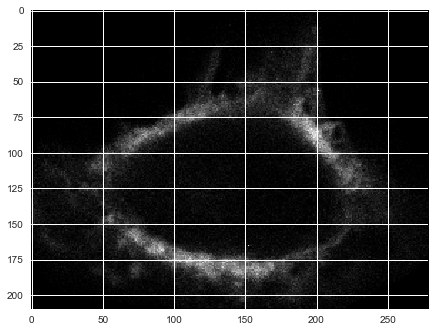

In [33]:
plt.imshow(images[2], cmap="gray")
plt.show()

In [39]:
array_DAPI = df['chan1'].values.reshape(-1, 1)
array_CD9 = df['chan3'].values.reshape(-1, 1)

shape = images[0].shape

In [50]:
model = LinearRegression(fit_intercept=False)
model.fit(array_DAPI, array_CD9)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [52]:
cd9_predictions = model.predict(array_DAPI)
dapi_predictions = model.predict(array_CD9)

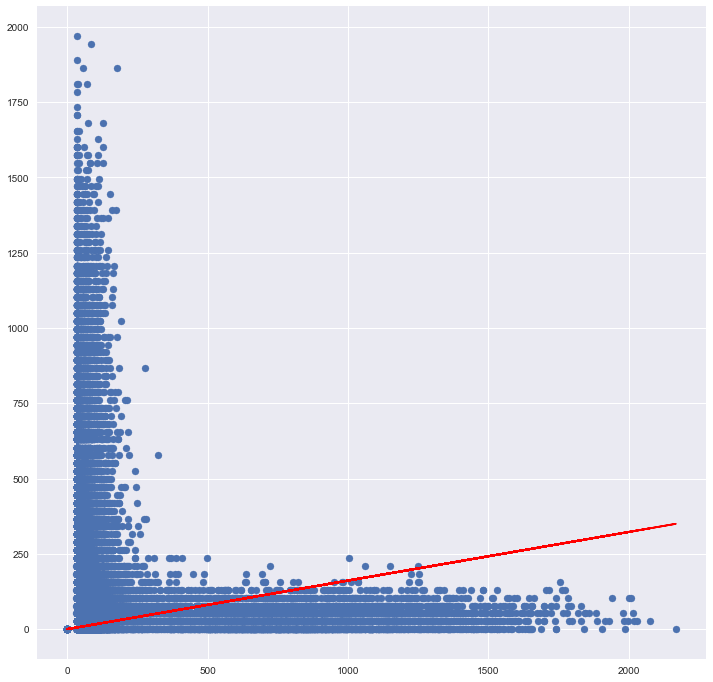

In [53]:
fig = plt.figure(figsize=(12,12))

plt.scatter(array_DAPI, array_CD9)
plt.plot(array_DAPI, cd9_predictions, color = "red")

plt.show()

In [57]:
cd9_residuals = array_CD9 - cd9_predictions
cd9_residual_norm = cd9_residuals / (array_DAPI +1)

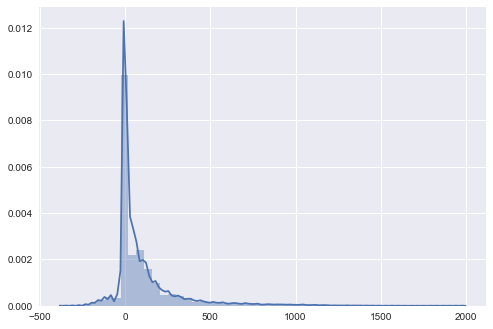

In [61]:
sns.distplot(cd9_residuals)
plt.show()

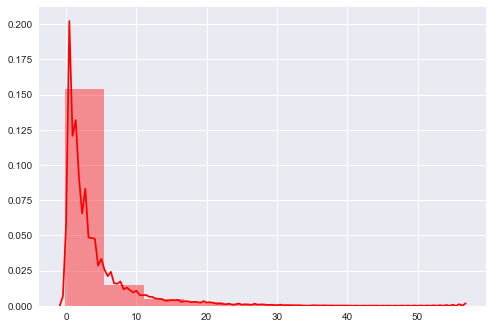

In [62]:
sns.distplot(cd9_residual_norm, color = "red", bins = 10)
plt.show()

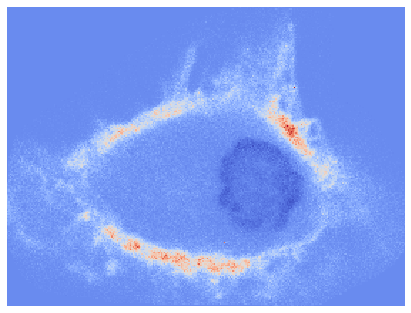

In [71]:
plt.imshow(cd9_residuals.reshape(shape), cmap="coolwarm")
plt.xticks(())
plt.yticks(())
plt.show()

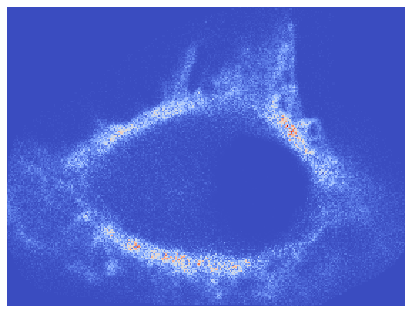

In [70]:
plt.imshow(cd9_residual_norm.reshape(shape), cmap="coolwarm")
plt.xticks(())
plt.yticks(())
plt.show()